# Climate Data Demo

Climate data can often times be very large, often exceeding several Petabytes (1,000,000 GB) for a single ensemble. The test case we will use here is data from the Community Earth System Model v2 (CESM2) Large Ensemble. With the CESM2-LE dataset, we have 100 members which span from 1850 to 2100, at 1 degree resolution. The total storage size of this dataset is roughly 4 PB. In this example, we will walk through a subset of this dataset, apply some calculations, and visualize the output.

### Imports

In [4]:
#Import something here
import intake
from distributed import Client, LocalCluster
import xarray as xr

In [2]:
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49755,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:49773,Total threads: 4
Dashboard: http://127.0.0.1:49775/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:49758,


## Data Access
The data we are using in this example is stored on Amazon's servers, in a storage facility similar to the one shown below

![amazon](images/amazon_servers.jpeg)

The original data were pre-processed, and converted into a cloud-optimized storage format, called [`Zarr`](https://zarr.readthedocs.io/en/stable/), with the data pre-"chunked", making it easier to subset and process.



### Read the Data into Xarray
We will take a look at 4 dimensional temperature data, with dimensions:
* Time (monthly frequency)
* Lev (vertical coordinate)
* Lat (latitude)
* Lon (longitude)

We also have a "member id" dimension, which represents each ensemble member

You'll notice upon reading in the data, our data (temperature) is chunked along the time dimension, with a total size of around 300 GB. This would be tough to load into memory, or even download onto your computer...

In [31]:
atmospheric_ds = xr.open_zarr('s3://ncar-cesm2-lens/atm/monthly/cesm2LE-ssp370-cmip6-T.zarr', storage_options={'anon':True})
atmospheric_ds

<xarray.Dataset>
Dimensions:    (member_id: 50, time: 1032, lev: 32, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lev        (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    T          (member_id, time, lev, lat, lon) float32 dask.array<chunksize=(1, 24, 32, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    host:              mom1
    logname:           sunseon
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    source:            CAM
    time_period_freq:  month_1
    topography_file:   /mnt/lustre/share/CESM/cesm_input/atm/cam/topo/fv_0.9x...

#### Access the Grid Information
We will need some grid information in order to properly calculate a global mean temperature. A schematic of the grid is shown below, with 1 degree horizontal resolution.

![global_grid](images/global_grid.png)

In [35]:
atmospheric_grid = xr.open_zarr('s3://ncar-cesm2-lens/atm/static/grid.zarr', storage_options={'anon':True})[['area']]
atmospheric_grid

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
    area     (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    P0       float64 ...
    gw       (lat) float64 dask.array<chunksize=(192,), meta=np.ndarray>
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    ntrk     int32 ...
    ntrm     int32 ...
    ntrn     int32 ...
    time     object ...
    wnummax  (lat) int32 dask.array<chunksize=(192,), meta=np.ndarray>
Data variables:
    *empty*

We can plot a quick visualization of the grid here!

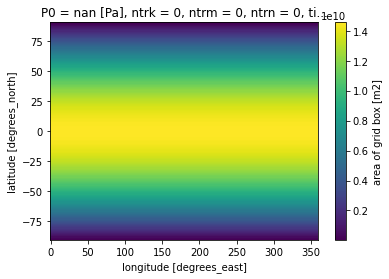

In [38]:
atmospheric_grid.area.plot()

## Visualize a Single Point

We can visualize this data at a single point, by:
* Defining our lat/lon (using Valpo as our default location) and subsetting accordingly
* Selecting the lowest level of the atmosphere
* Plot our output!

### Subset for Valpo's Location
Valpo is situated at the following lat/lon - feel free to change this to the location of your choosing!

In [39]:
lat = 41.4639
lon = 87.0439

Once we define our lat and lon, we can subset using `xarray`!

In [42]:
valpo_subset = atmospheric_ds.sel(lat=lat, lon=lon, method='nearest')
valpo_subset

<xarray.Dataset>
Dimensions:    (member_id: 50, time: 1032, lev: 32, nbnd: 2)
Coordinates:
    lat        float64 40.99
  * lev        (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
    lon        float64 87.5
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    T          (member_id, time, lev) float32 dask.array<chunksize=(1, 24, 32), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    host:              mom1
    logname:           sunseon
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    source:            CAM
    time_period_freq:  month_1
    topography_file:   /mnt/lustre/share/CESM/cesm_input/atm/cam/topo/fv_0.9x...

We can load this smaller set of data into memory, using `.load()`!

In [ ]:
valpo_temp_ds = valpo_subset.load()

## Calculate a Global Mean Temperature and Plot It

A common field to plot is a global average of a field. In order to calculate this though, we need to weight our calculation properly, using the area of each cell. Fortunately, we subset for this when we loaded in the grid 👍

### Subset the area and load it into memory

In [ ]:
cell_area = atmospheric_grid.area.load()

### Subset temperature for the lowest pressure level

In [ ]:
temp_lowest_level = atmospheric_ds.sel(lev=-1)

In [ ]:
temp_lowest_level.isel(member_id=0).plot()

### Calculate the Annual Average Temperature 

In [ ]:
global_annual_average_temperature = (temp_lowest_level.resample(time="AS").mean("time")).weighted(cell_area).mean(('lat', 'lon'))

### Visualize the Output

In [ ]:
global_annual_average_temperature.hvplot.line()

In [ ]:
# Read in the data using xarray or some other package
ds = xr.open_dataset('some_file.nc')